# Avazu - Click-Through Rate Prediction

Julia Kang - jkang613@gmail.com - AMLI 2019 - Mills College

**References:**  
Original Source: https://www.kaggle.com/c/avazu-ctr-prediction   
Sample Data Preprocessing: https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff  
Wining Solution: https://www.csie.ntu.edu.tw/~r01922136/slides/kaggle-avazu.pdf   
Sample Logisitic Reg: https://turi.com/learn/gallery/notebooks/click_through_rate_prediction_intro.html  
Another Medium post: https://becominghuman.ai/predicting-click-probabilities-on-a-leading-advertising-platform-7582633e6e78  
Logistic Reg: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8   
Random Forests - Tuning: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d   




# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import psutil
import random
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
# from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from math import sqrt #for RMSE
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import roc_curve, auc


# #to visual random forest
# import pydotplus
# from IPython.display import Image  
# from sklearn.externals.six import StringIO  

import tensorflow as tf 
from tensorflow.feature_column import numeric_column,categorical_column_with_hash_bucket,categorical_column_with_vocabulary_list
from tensorflow.estimator import LinearClassifier
from tensorflow import keras
from tensorflow.data import Dataset

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load in Data

In [6]:
#read in the original csv file

# df = pd.read_csv('../data/train_sample.csv')

# df.head()

In [7]:
# Check the number of cores and memory usage
# num_cores = mp.cpu_count()
# print("This kernel has ",num_cores,"cores and you can find the information regarding the memory usage:",psutil.virtual_memory())

In [8]:
# p = 0.01  # 1% of the lines
# # keep the header, then take only 1% of lines
# # if random from [0,1] interval is greater than 0.01 the row will be skipped
# filename = '../data/train_ds.csv'

# df_new = pd.read_csv(
#          filename,
#          header=0, 
#          skiprows=lambda i: i>0 and random.random() > p
# )


# IN THE FUTURE: WE CAN STRATIFY/CREATE SUBSETS BASED ON SPECIFIC FEATURES

In [9]:
#view the shape of the randomly selected sample we generated
# df_new.shape

In [10]:
# df_new.head()

In [11]:
#create new csv that is randomly sampled from originally training set that has 404,410 rows - it's been moved to the
#data folder

# df_new.to_csv("rand_sample_csv.csv")

In [120]:
# #read the csv file we created and make sure to pass the 'hour' column as the correct dtype

# sub_df = pd.read_csv('rand_sample_csv.csv', parse_dates=['hour'])

In [121]:
# sub_df.head() #preview the data

,Unnamed: 0,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,...,1,0,20352,320,50,2333,0,39,-1,157
1,1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15706,320,50,1722,0,35,-1,79
2,2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,...,0,0,21692,216,36,2497,3,43,100151,42
3,3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15705,320,50,1722,0,35,-1,79
4,4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15701,320,50,1722,0,35,-1,79


In [122]:
# #Drop the original indexing column known as "Unnamed: 0"
# sub_df.columns #read through the column names so we can delete the first column since it is useless
# sub_df = sub_df.drop('Unnamed: 0', axis = 1) 

In [123]:
# sub_df.head() #check to make sure the column deletion was successful

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20352,320,50,2333,0,39,-1,157
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,0,21692,216,36,2497,3,43,100151,42
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15705,320,50,1722,0,35,-1,79
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,-1,79


# Feature Engineering

In [124]:
# # feature engineering - work on the hour column and separate the hour and time into new columns
# parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
# sub_df['new_hour'] = sub_df['hour'].apply(parse_date)
# # sub_df['new_hour']

In [125]:
# sub_df['new_date'] = [d.date() for d in sub_df['new_hour']]
# sub_df['new_time'] = [d.time() for d in sub_df['new_hour']]

In [126]:
# day_of_week = lambda val : val.weekday()
# sub_df['day_of_week'] = sub_df['new_date'].apply(day_of_week) #Monday is 0 and Sunday is 6

#IN THE FUTURE LETS USE ONE HOT ENCODER

In [127]:
# sub_df.head() #check if column creation was successful

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C16,C17,C18,C19,C20,C21,new_hour,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,50,2333,0,39,-1,157,2014-10-21,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,-1,79,2014-10-21,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,36,2497,3,43,100151,42,2014-10-21,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,-1,79,2014-10-21,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,-1,79,2014-10-21,2014-10-21,00:00:00,1


In [128]:
# sub_df = sub_df.drop('new_hour', axis = 1) #drop the 'new_hour' column do eliminate redundancy 

In [129]:
# sub_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


# ***RUN THE CODE FROM HERE:  ***

**Notes from Josh:** (4/1)

Create subsets of the data using device id, website, location, etc..and get understanding from that.

Outliers - zero/mean - describe the data

Normalize/standardize

Find the best application of random forest

Neural Network - TensorFlow / Linear classifier / Keras - no recurrent/no convolusion - just basic neural network

Data discovery/hyper parameters

KNN/K-means - find natural clusters of ads - use as discovery and bucketize the column - ads

In [3]:
# sub_df.to_csv("rand_sample_eng.csv") #export as a csv so save for future use

sub_df = pd.read_csv('rand_sample_eng.csv')

In [4]:
# sub_df = sub_df.drop('hour', axis = 1) 
sub_df = sub_df.drop('Unnamed: 0', axis = 1) 

In [5]:
sub_df.head() #ad id is unique to each row
# len(sub_df)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


In [6]:
len(sub_df['id'].unique()) 

404410

**Summary:** We see that ad id is a unique value

In [7]:
#check for null and empty values - There are none
sub_df.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
new_date            0
new_time            0
day_of_week         0
dtype: int64

**Summary:** We see that there is no empty, null, na, etc. values 

# Clicks

In [8]:
#see what percentage of people click and what percentage of people do not click
# click = 16.9991% no click = 83.0009%
sub_df['click'].value_counts()/404410

0    0.830009
1    0.169991
Name: click, dtype: float64

In [9]:
#Find the start and end date of the data
print(sub_df['new_date'].min(), sub_df['new_date'].max())

2014-10-21 2014-10-30


**Note:** Our dataset ranges from 10/21/2014 to 10/30/2014. It spans a total of 10 days.

### Clicks per hour

In [10]:
clicks = sub_df.groupby('hour').agg({'click':'sum'})
# clicks

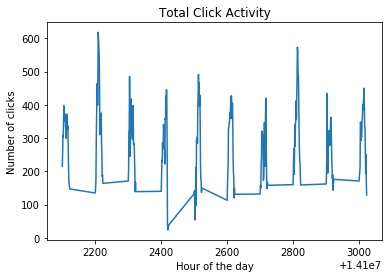

In [11]:
plt.plot(clicks)
plt.ylabel('Number of clicks')
plt.xlabel('Hour of the day')
plt.title('Total Click Activity')
plt.show()
#Change x-axis

**Summary:** From our graph we that user activity fluctuated greated throughout the day

In [12]:
clicks_details = sub_df.groupby(['new_date','new_time']).size().unstack()
clicks_details

new_time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
new_date,,,,,,,,,,,,,,,,,,,,,
2014-10-21,1182,1400,2061,1875,2611,2673,2395,2077,2116,2282,...,1786,1767,1767,1668,1527,1246,1062,922,830,744
2014-10-22,794,926,1011,1376,2020,2892,2881,2244,3227,4442,...,1798,1823,1886,1984,2113,1772,1491,1215,1078,938
2014-10-23,879,1052,1533,1777,2777,2257,1400,1563,2381,1811,...,1745,2477,1690,1601,1494,1394,1355,1224,1049,895
2014-10-24,789,927,1213,1228,1644,1664,1644,1769,1676,1725,...,2160,2029,2624,2513,1636,310,200,238,144,246
2014-10-25,726,795,402,675,762,1209,514,1374,1546,1795,...,2394,2515,2105,2111,1930,1215,1004,896,863,800
2014-10-26,720,828,991,1106,1507,1725,1773,1922,1917,2090,...,2323,2013,1980,1873,1530,1185,1014,815,879,809
2014-10-27,646,738,847,1190,1348,1730,1807,1692,1607,1522,...,1062,1075,1788,2356,2089,1590,1016,963,950,871
2014-10-28,811,1040,1750,1178,1376,1753,1804,2085,2858,3278,...,3898,2817,2849,2886,2363,1991,1682,1582,1253,1167
2014-10-29,1000,1176,1404,2305,1588,1299,1397,2317,2034,1921,...,2255,2028,1825,1588,1369,1241,1157,954,942,977


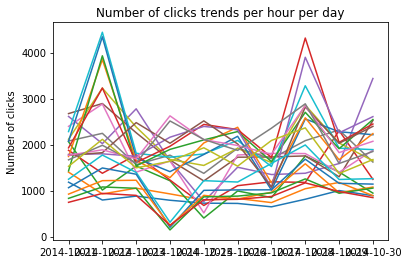

In [13]:
plt.plot(clicks_details)
plt.figsize=(24,12)
plt.ylabel('Number of clicks')
plt.title('Number of clicks trends per hour per day') 
plt.show()

In [14]:
clicks_per_hour = sub_df.groupby('new_time').agg({'click': 'sum'})
# clicks_per_hour

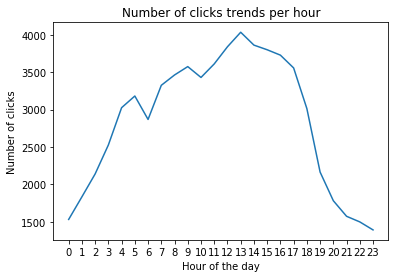

In [15]:
plt.plot(clicks_per_hour)
plt.ylabel('Number of clicks')
plt.xlabel('Hour of the day')
plt.title('Number of clicks trends per hour') 
x = range(0,24)
plt.xticks(range(24), x)
plt.figsize=(12,6)

**Summary:** The greatest click activity occurs mid-day around 12pm.

### Clicks per Day of the Week

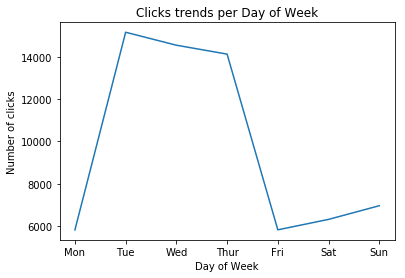

In [16]:
clicks_per_dow = sub_df.groupby('day_of_week').agg({'click':'sum'})
plt.plot(clicks_per_dow)
x = ['Mon', 'Tue', 'Wed','Thur','Fri','Sat','Sun']
plt.xticks(range(7), x)

plt.ylabel('Number of clicks')
plt.xlabel('Day of Week')
plt.title('Clicks trends per Day of Week') 
plt.figsize=(12,6)
plt.show()

**Summary:** Ads experience the most activity Tuesday-Thursday and the least amount of activity Monday and Friday. 

# Impressions

### Impressions by Hour

In [17]:
# ORDER MATTERS
click_per_view_per_hour = sub_df.groupby(['new_time','click']).size().unstack()
click_per_view_per_hour['total'] = click_per_view_per_hour.sum(axis=1)
# click_per_view_per_hour

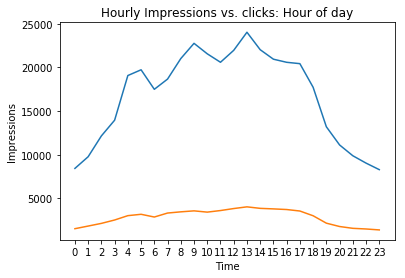

In [18]:
# plt.plot(click_per_view_per_hour, figsize = (12,6))
plt.plot(click_per_view_per_hour['total'])
plt.plot(click_per_view_per_hour[1])
plt.ylabel('Impressions')
plt.xlabel('Time')
x = range(0,24)
plt.xticks(range(24), x)
plt.title('Hourly Impressions vs. clicks: Hour of day')
plt.show()

#Can't get it to a bar graph...?

**Summary:** From our graph we can see that Impressions and Clicks are generally lower around midnight, and high during noon.

### Impressions by day of week

In [19]:
# ORDER MATTERS
click_per_view_per_dow = sub_df.groupby(['day_of_week','click']).size().unstack()
click_per_view_per_dow['total'] = click_per_view_per_dow.sum(axis=1)
click_per_view_per_dow

click,0,1,total
day_of_week,,,
0,26597,5816,32413
1,78575,15161,93736
2,77396,14548,91944
3,67107,14127,81234
4,27110,5820,32930
5,27675,6314,33989
6,31204,6960,38164


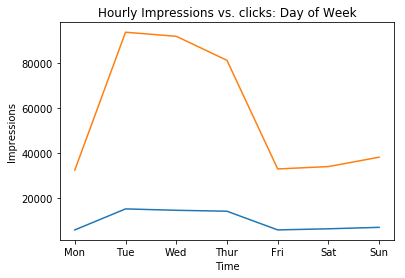

In [20]:
# plt.plot(click_per_view_per_hour, figsize = (12,6))
plt.plot(click_per_view_per_dow[1])
plt.plot(click_per_view_per_dow['total'])
x = ['Mon', 'Tue', 'Wed','Thur','Fri','Sat','Sun']
plt.xticks(range(7), x)
plt.ylabel('Impressions')
plt.xlabel('Time')
plt.title('Hourly Impressions vs. clicks: Day of Week')
plt.show()


# CTR

### CTR by Hour

**Formula** CTR = Clicks : Impressions

In [21]:
CTR_per_hourofday = click_per_view_per_hour[1]/click_per_view_per_hour['total']
CTR_per_hourofday

new_time
00:00:00    0.181624
01:00:00    0.187679
02:00:00    0.176045
03:00:00    0.181095
04:00:00    0.158634
05:00:00    0.161251
06:00:00    0.163961
07:00:00    0.178106
08:00:00    0.164779
09:00:00    0.157057
10:00:00    0.159067
11:00:00    0.175345
12:00:00    0.174858
13:00:00    0.167860
14:00:00    0.175277
15:00:00    0.181423
16:00:00    0.181054
17:00:00    0.174066
18:00:00    0.169986
19:00:00    0.163978
20:00:00    0.160237
21:00:00    0.159231
22:00:00    0.165800
23:00:00    0.167852
dtype: float64

Text(0.5,1,'CTR per Hour of Day')

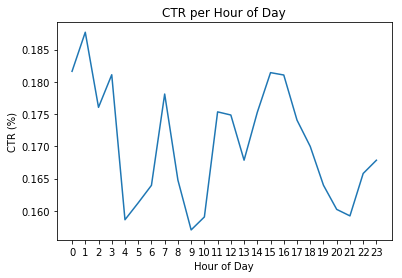

In [22]:
plt.plot(CTR_per_hourofday)
plt.ylabel('CTR (%)')
plt.xlabel('Hour of Day')
x = range(0,24)
plt.xticks(range(24), x)
plt.title('CTR per Hour of Day')

**Summary:** From our graph we can see that CTR is highest at 12-3am, 11-12am, 3-4pm.

### CTR by Day of Week

In [23]:
CTR_per_dow = click_per_view_per_dow[1]/click_per_view_per_dow['total']
CTR_per_dow

day_of_week
0    0.179434
1    0.161741
2    0.158227
3    0.173905
4    0.176739
5    0.185766
6    0.182371
dtype: float64

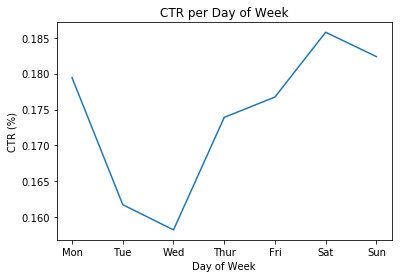

In [24]:
plt.plot(CTR_per_dow)
plt.ylabel('CTR (%)')
plt.xlabel('Day of Week')
plt.title('CTR per Day of Week')
x = ['Mon', 'Tue', 'Wed','Thur','Fri','Sat','Sun']
plt.xticks(range(7), x)
plt.show()

**Summary:** We can see very low CTR on Wednesdays and high CTR on Saturdays and Sunday. "Apparently, people have more time to click over the weekend."

# Exploring the Other Features

In [25]:
# Still need to explore banner position, device type, and C# and their relationship to CTR/

## Feature: C1, C14 - C21

In [26]:
# print(len(sub_df['device_ip'].unique()))
# print(sub_df['new_time'].value_counts()/len(sub_df['new_time']))

#explore distribution of categorical features
print(sub_df['C1'].value_counts()/len(sub_df['C1']))
# replace device_ip values occurring less than 5 times with a dummy
test = sub_df['device_ip'].value_counts() #LARGE VARIETY
# print(sub_df['C14'].value_counts()/len(sub_df['C14'])) #LARGE VARIETY
print(sub_df['C15'].value_counts()/len(sub_df['C15']))
print(sub_df['C16'].value_counts()/len(sub_df['C16']))
# print(sub_df['C17'].value_counts()/len(sub_df['C17'])) #LARGE VARIETY
print(sub_df['C18'].value_counts()/len(sub_df['C18']))
# print(sub_df['C19'].value_counts()/len(sub_df['C19'])) #LARGE VARIETY
# print(sub_df['C20'].value_counts()/len(sub_df['C20'])) #LARGE VARIETY
# print(sub_df['C21'].value_counts()/len(sub_df['C21'])) #MEDIUM-LARGE VARIETY
# print(sub_df['banner_pos'].value_counts()/len(sub_df['banner_pos']))
# print(sub_df['site_domain'].value_counts()/len(sub_df['site_domain']))


1005    0.919290
1002    0.054583
1010    0.022064
1012    0.002816
1007    0.000853
1001    0.000257
1008    0.000136
Name: C1, dtype: float64
320     0.932484
300     0.057996
216     0.007586
728     0.001728
120     0.000082
1024    0.000052
480     0.000045
768     0.000027
Name: C15, dtype: float64
50      0.943122
250     0.044885
36      0.007586
480     0.002473
90      0.001728
20      0.000082
768     0.000052
320     0.000045
1024    0.000027
Name: C16, dtype: float64
0    0.418954
3    0.336683
2    0.177013
1    0.067350
Name: C18, dtype: float64


In [27]:
test = sub_df['device_ip'].value_counts()
test = pd.DataFrame(test)

# temp_sub_df['test'] = test
# temp_sub_df.head()

**Summary:** Most ads are C1 = 1005 (91.9290%), C15 = 320 (93.2484%), C16 = 50 (94.3122%), C18 = 0 (41.8954%), C20=-1 (46.8198%), C21 = 23 (22.0373%).

In [28]:
#Lets remove C14, C17, and C19 - These features do not seem to reveal much about the dataset.

# sub_df = sub_df.drop('C14', axis = 1) 
# sub_df = sub_df.drop('C17', axis = 1) 
# sub_df = sub_df.drop('C19', axis = 1) 


In [29]:
print(sub_df['device_type'].value_counts()/len(sub_df['device_type']))

1    0.923350
0    0.054583
4    0.018981
5    0.003084
2    0.000002
Name: device_type, dtype: float64


In [30]:
print(len(sub_df['device_id'].value_counts()))

64913


**Summary:** Most of the user activity is through using device type 1 (92.335%).

# Modeling!!!

### Encoding and Selecting Key Features

In [31]:
sub_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


In [32]:
# drop the columns with unqiue values or large volume of category types
# temp_sub_df = sub_df.drop(['id','hour','C14','C17','C19','site_id','site_domain','app_id','device_id'], axis =1)

temp_sub_df = sub_df
temp_sub_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,10004510652136496837,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,10076859283156800622,0,14102100,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,10078825124049580646,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,10085233430943183912,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


In [33]:
temp_sub_df.dtypes

id                  uint64
click                int64
hour                 int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
new_date            object
new_time            object
day_of_week          int64
dtype: object

In [34]:
# func = lambda val : val.hour
# train['hour'] = train['new_time'].apply(func)

# convert new_time column of type datetime to float and create new column called 'hour'
func = lambda val : (pd.datetime.strptime(val, '%H:%M:%S')).hour

temp_sub_df['hour'] = temp_sub_df['new_time'].apply(func)

In [35]:
temp_sub_df.head()
# train = train.drop(['hours'],axis=1)
# train.dtypes

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C15,C16,C17,C18,C19,C20,C21,new_date,new_time,day_of_week
0,10004510652136496837,0,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,320,50,2333,0,39,-1,157,2014-10-21,00:00:00,1
1,10007164336863914220,1,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
2,10076859283156800622,0,0,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,216,36,2497,3,43,100151,42,2014-10-21,00:00:00,1
3,10078825124049580646,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1
4,10085233430943183912,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,320,50,1722,0,35,-1,79,2014-10-21,00:00:00,1


In [36]:
# binary_classifier = linear_model.SGDClassifier(
#   random_state=2, # Specifying random state allow us to get repeatable outcomes
#   tol=1e-3, 
#   max_iter=500) 

# binary_classifier.fit(train[FEATURES], train['click'])

In [37]:
#Explore how many categories we have for each feature

len(temp_sub_df['banner_pos'].unique())

#141 app_domains
#21 site_categories
#25 app_categories
#217066 device_ips
#4170 device_models
#5 device_types


7

In [38]:
#Tried ONE HOT ENCODER - failed. Does not seem to like string inputs. Might have to use LabelEncoder first and then 
# ONE HOT ENCODER?? will revisit..

#Look into pandas.get_dummies

## When it comes to label encoding if you see trends with data then try shuffling the data and relabeling


# ohe_site_category = OneHotEncoder(categorical_features=[21])
# test = ohe_site_category.fit_transform(new_train['site_category']).toarray()

In [39]:
# #create a new training dataset with the features we have selected - avoid overwriting the original training data

# new_temp_sub_df = temp_sub_df[FEATURES]
# new_temp_sub_df['click'] = temp_sub_df[TARGET]
# new_temp_sub_df.dtypes

In [40]:
# Encoding for only 3 of the columns for the sake of time - using LabelEncoder()
# Create new columns for the encoded values so have the original values for reference

le_site_category = LabelEncoder()
temp_sub_df['enc_app_domain'] = le_site_category.fit_transform(temp_sub_df['app_domain'])
temp_sub_df['enc_site_category'] = le_site_category.fit_transform(temp_sub_df['site_category'])
temp_sub_df['enc_app_category'] = le_site_category.fit_transform(temp_sub_df['app_category'])

temp_sub_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C18,C19,C20,C21,new_date,new_time,day_of_week,enc_app_domain,enc_site_category,enc_app_category
0,10004510652136496837,0,0,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,0,39,-1,157,2014-10-21,00:00:00,1,65,3,0
1,10007164336863914220,1,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,35,-1,79,2014-10-21,00:00:00,1,65,1,0
2,10076859283156800622,0,0,1002,0,f17ebd97,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,3,43,100151,42,2014-10-21,00:00:00,1,65,5,0
3,10078825124049580646,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,35,-1,79,2014-10-21,00:00:00,1,65,1,0
4,10085233430943183912,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,35,-1,79,2014-10-21,00:00:00,1,65,1,0


In [41]:
# Features with the appropriate encoded column names to use to train our model

FEATURES = ['C1', 'banner_pos', 'enc_site_category', 'enc_app_domain',
       'enc_app_category', 'device_type',
       'device_conn_type', 'C15', 'C16', 'C18', 'C20', 'C21', 'day_of_week',
           'hour']
TARGET = ['click']

In [42]:
# split the data into test and train
train, test  = train_test_split(
  temp_sub_df,                        # split our digits dataframe
  stratify=temp_sub_df[TARGET],       # stratify by the 'click' column   
  test_size=0.2,                # 20% of the data should be held for testing
  random_state=42               # hard-coded random state for repeatability in the example
)

train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C18,C19,C20,C21,new_date,new_time,day_of_week,enc_app_domain,enc_site_category,enc_app_category
242327,17016179924101047753,0,4,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,3,297,100111,61,2014-10-27,04:00:00,0,75,5,3
274613,13362092218668200074,1,3,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,2,1063,-1,33,2014-10-28,03:00:00,1,65,19,0
323457,11914295786743937713,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,0,35,-1,51,2014-10-29,00:00:00,2,65,1,0
275743,12379328275205309290,0,4,1005,1,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,...,0,39,100081,221,2014-10-28,04:00:00,1,65,19,0
394154,15603282462457099589,0,16,1005,1,222acd54,de0f0f82,f028772b,ecad2386,7801e8d9,...,0,935,100075,48,2014-10-30,16:00:00,3,65,19,0


### Logisitic Regression -  Classification using ScikitLearn

In [43]:
# Start of LogisticRegression Model!!

model = LogisticRegression()
model.fit(train[FEATURES], train[TARGET]) #**** Make sure we are using the properly encoded features ***

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
# Seeing how our model performs on the SAME TRAINING DATA
predictions = model.predict(test[FEATURES])

In [45]:
#*******metrics******

cnf_matrix = metrics.confusion_matrix(test[TARGET], predictions)
print(cnf_matrix)
print()
print("Accuracy:",metrics.accuracy_score(test[TARGET], predictions))
print("Precision:",metrics.precision_score(test[TARGET], predictions))
print("Recall:",metrics.recall_score(test[TARGET], predictions))

[[66983   150]
 [13677    72]]

Accuracy: 0.8290472540243812
Precision: 0.32432432432432434
Recall: 0.005236744490508401


**Summary:** Looks like we have a pretty high number of incorrect predictions :(

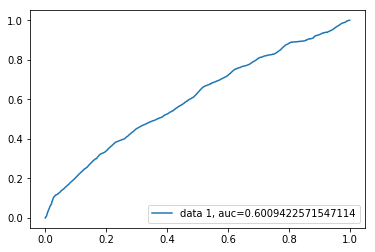

In [46]:
#ROC Curve

y_pred_proba = model.predict_proba(test[FEATURES])[::,1]
fpr, tpr, _ = metrics.roc_curve(test[TARGET],  y_pred_proba)
auc = metrics.roc_auc_score(test[TARGET], y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**Summary:** Yikes...

## Random Forests  - Classification using sklearn

In [47]:
#take preprocessed data from above for train and test set
train_features = np.array(train[FEATURES])
train_labels = np.array(train[TARGET])
test_features = np.array(test[FEATURES])
test_labels = np.array(test[TARGET])

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (323528, 14)
Training Labels Shape: (323528, 1)
Testing Features Shape: (80882, 14)
Testing Labels Shape: (80882, 1)


In [48]:
# Instantiate model with 10 decision trees - this will be our baseline model
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels.ravel()) #use ravel() - it flattens the array

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [49]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

In [50]:
#reshape predictions to have 1 column to later use to concatenate
predictions = predictions.reshape(80882,1)
print(predictions.shape)

(80882, 1)


In [51]:
#create dataframe that compares the actual vs predicted
results = pd.DataFrame(np.column_stack((test_labels, predictions)))

# results

In [52]:
RMSE = sqrt(metrics.mean_squared_error(test_labels, predictions))
print("RMSE when n_estimators = 10 is {}".format(RMSE))
# #RMSE: 0.4315343595981214 with n_estimators = 10

RMSE when n_estimators = 10 is 0.4315343595981214


**Summary:** Baseline error is still not great

We will use AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it’s a binary classification problem. AUC is a good way for evaluation for this type of problems.

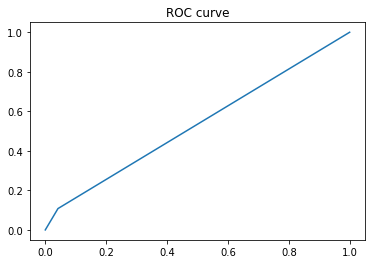

AUC when n_estimators = 10 is 0.5331646979693431


In [53]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.show()

print("AUC when n_estimators = 10 is {}".format(roc_auc))



### Random Forest - Parameter Tuning

In [54]:
#try different n_estimators to see if we can find an optimal number of trees
n_estimators = [1, 10, 64, 225, 500]

rmse_results = []
auc_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, random_state = 42)
    rf.fit(train_features, train_labels.ravel())
    predictions = (rf.predict(test_features)).reshape(80882,1)
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, predictions)
    
    #metrics
    roc_auc = metrics.auc(fpr, tpr)
    auc_results.append(roc_auc)
    RMSE = sqrt(metrics.mean_squared_error(test_labels, predictions))
    rmse_results.append(RMSE)
    
    print(("Model where n_estimator = {} completed").format(estimator))

Model where n_estimator = 1 completed
Model where n_estimator = 10 completed
Model where n_estimator = 64 completed
Model where n_estimator = 225 completed
Model where n_estimator = 500 completed


In [55]:
rmse_results
# auc_results

[0.44603154691922864,
 0.4315343595981214,
 0.4303006229913365,
 0.4298406542623384,
 0.42935139755914326]

**Summary:** YIKESSS....RMSE IS SO BAD

### SGDClassifer - scikit learn

**Logistic vs SGDClassifier:** Logistic Regression by default uses Gradient Descent and as such it would be better to use SGD Classifier on larger data sets. One another reason you might want to use SGD Classifier is, logistic regression, in its vanilla sklearn form, won’t work if you can’t hold the dataset in RAM but SGD will still work.

For sufficiently large datasets, it is best to implement SGD Classifier instead of Logistic Classifier to produce similar results in much less time.

In [56]:
sgd_classifier = linear_model.SGDClassifier(
    loss='log',
    random_state=2, # Specifying random state allow us to get repeatable outcomes
    tol=1e-3, 
    max_iter=500
) 
 
sgd_classifier.fit(train_features, train_labels.ravel())

# sgd_classifier.partial_fit(train_features, train_labels.ravel(), classes = [0,1]) #partial_fit SUCKED

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=500, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=2, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

In [57]:
# get the predictions using our model
sgd_predictions = sgd_classifier.predict(test_features)

# we can use the scores to set thresholds on the predictions made
sgd_scores = sgd_classifier.decision_function(test_features)
RMSE = sqrt(metrics.mean_squared_error(test_labels, sgd_predictions))
print(("Model using SGDClassifier has an RMSE of {} ").format(RMSE))
# 0.4158645213482616 - base
# 0.41513549509867104 - loss = log

Model using SGDClassifier has an RMSE of 0.41513549509867104 


In [58]:
# metrics - calculate the area under the ROC curve
sgd_fpr, sgd_tpr, sgd_thresholds = metrics.roc_curve(test_labels, sgd_predictions)
sgd_roc_auc = metrics.auc(sgd_fpr, sgd_tpr)
sgd_roc_auc

# 0.5205449402269007 - base
# 0.5226449901767597 - loss = log

0.5226449901767597

In [59]:
# loop through different C (alpha) values to see which gives us the largest AUC value
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

RMSES = []
AUCS = []

for a in alphas:
    sgd_classifier = linear_model.SGDClassifier(
        alpha = a,
        loss='log',
        random_state=2, # Specifying random state allow us to get repeatable outcomes
        tol=1e-3, 
        max_iter=500
    ) 

    sgd_classifier.fit(train_features, train_labels.ravel())
    sgd_predictions = sgd_classifier.predict(test_features)
    sgd_rmse = sqrt(metrics.mean_squared_error(test_labels, sgd_predictions))
    RMSES.append(sgd_rmse)
    sgd_fpr, sgd_tpr, sgd_thresholds = metrics.roc_curve(test_labels, sgd_predictions)
    sgd_roc_auc = metrics.auc(sgd_fpr, sgd_tpr)
    AUCS.append(sgd_roc_auc)
    
    print(("Model where alpha is {} is completed").format(a))

Model where alpha is 0.0001 is completed
Model where alpha is 0.001 is completed
Model where alpha is 0.01 is completed
Model where alpha is 0.1 is completed
Model where alpha is 1.0 is completed
Model where alpha is 10.0 is completed


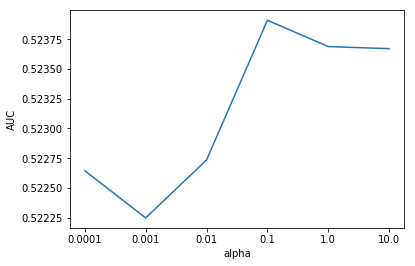

In [60]:
# plot to visiual the different AUC in relation to alpha 
plt.plot(AUCS)
plt.xticks(range(len(alphas)), alphas)
plt.ylabel('AUC')
plt.xlabel('alpha')
plt.show()

## Tensor Flow - LinearClassifier

In [236]:
# split the data
train_tf, test_tf = train_test_split(
  sub_df,
#   stratify=sub_df['click'],  
  test_size=0.2,
)


In [62]:
column_names = sub_df.columns
# sub_df.dtypes
column_names[5]

'site_id'

In [63]:
# get the index of each column and specify which ones will be created as numeric, vocab_list, or hash_bucket

numeric = []
for i in range(0,len(column_names)):
#     print(sub_df[column_names[i]].dtypes)
    if np.issubdtype(sub_df[column_names[i]].dtypes , np.number):
        numeric.append(i)
        
# vocab = []
# for i in range(0,len(column_names)):
# #     print(sub_df[column_names[i]].dtypes)
#     if np.issubdtype(sub_df[column_names[i]].dtypes , np.object_):
#         vocab.append(i)
# vocab.remove(12)

# hash_bucket = [12]
numeric

[0, 1, 2, 3, 4, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29]

In [72]:
column_names[1]

'click'

In [133]:
# declare the feature columns accordingly

feature_columns = []

for num_col in numeric:
    if column_names[num_col] != "click":
        feature_columns.append(numeric_column(column_names[num_col], dtype=tf.dtypes.int64))

# for num_col in vocab:
#   feature_columns.append(categorical_column_with_vocabulary_list(
#       column_names[num_col],
#         sub_df[column_names[num_col]].unique()
#          ))

# for num_col in hash_bucket:
#   feature_columns.append(categorical_column_with_hash_bucket(
#       column_names[num_col],
#       len(sub_df[column_names[num_col]].unique())
#          ))

In [92]:
feature_columns 

[NumericColumn(key='id', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='hour', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='C1', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='banner_pos', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='device_type', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='device_conn_type', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='C14', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='C15', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='C16', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='C17', shape=(1,), default_value=None, dtype=tf.int64, normalizer_fn=None),
 NumericColumn(key='C18

In [93]:
# We now know our feature columns. We also know how many classes we need to identify.
# To build the classifier we simply feed that data into the object constructor.

classifier = LinearClassifier(feature_columns=feature_columns, n_classes=2)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/9h/j8xlvbk14vx9yqsgthf07z7h0000gn/T/tmp7gl0vlkp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1ae61e1550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/9h/j8xlvbk14vx9yqsgthf07z7h0000gn/T/tmp7gl0vlkp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1ae61e1550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [94]:
def training_input():
    
    features0 = {}
    for col in numeric:
 #         print(column_names[num_col])
        if column_names[col] != "click":
            features0[column_names[col]] = train_tf[column_names[col]]
    
    print(features0.keys())
    labels = train_tf['click']

    training_ds = Dataset.from_tensor_slices((features0, labels))
#     training_ds = training_ds.shuffle(buffer_size=10000)
    training_ds = training_ds.batch(100)
#     training_ds = training_ds.repeat(5)

    return training_ds

classifier.train(training_input)

dict_keys(['id', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'day_of_week', 'enc_app_domain', 'enc_site_category', 'enc_app_category'])
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /var/folders/9h/j8xlvbk14vx9yqsgthf07z7h0000gn/T/tmp7gl0vlkp/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /var/folders/9h/j8xlvbk14vx9yqsgthf07z7h0000gn/T/tmp7gl0vlkp/model.ckpt.


UnimplementedError: CopySliceToElement Unhandled data type: 23
	 [[node IteratorGetNext (defined at /anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/util.py:110) ]]

Caused by op 'IteratorGetNext', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-94-00b3e6b5f9b3>", line 19, in <module>
    classifier.train(training_input)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 358, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1124, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1151, in _train_model_default
    input_fn, model_fn_lib.ModeKeys.TRAIN))
  File "/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 992, in _get_features_and_labels_from_input_fn
    self._call_input_fn(input_fn, mode))
  File "/anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/util.py", line 110, in parse_input_fn_result
    result = iterator.get_next()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

UnimplementedError (see above for traceback): CopySliceToElement Unhandled data type: 23
	 [[node IteratorGetNext (defined at /anaconda3/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/util.py:110) ]]


In [88]:
train_tf['click'].dtypes

dtype('int64')

In [90]:
train_tf.dtypes

id                   uint64
click                 int64
hour                  int64
C1                    int64
banner_pos            int64
site_id              object
site_domain          object
site_category        object
app_id               object
app_domain           object
app_category         object
device_id            object
device_ip            object
device_model         object
device_type           int64
device_conn_type      int64
C14                   int64
C15                   int64
C16                   int64
C17                   int64
C18                   int64
C19                   int64
C20                   int64
C21                   int64
new_date             object
new_time             object
day_of_week           int64
enc_app_domain        int64
enc_site_category     int64
enc_app_category      int64
dtype: object

In [ ]:
input_func = tf.estimator.inputs.pandas_input_fn(
    x=train_tf[column_names[numeric]],
    y=train_tf['click'],
    batch_size=10,
    num_epochs=100,
    shuffle=True)

classifier.train(input_fn=input_func)

## TensorFlow - Basic Neural Network

In [95]:
from tensorflow import keras


In [237]:
#train
train_tf_x = []
for col_num in numeric:
    if column_names[col_num] != 'click':
        train_tf_x.append(train_tf[column_names[col_num]])
    
train_x = np.asarray(train_tf_x)
train_x = np.transpose(train_x)

train_y = np.asarray(train_tf['click'])

#test
test_tf_x = []
for col_num in numeric:
    if column_names[col_num] != 'click':
        test_tf_x.append(test_tf[column_names[col_num]])
    
test_x = np.asarray(test_tf_x)
test_x = np.transpose(test_x)

test_y = np.asarray(test_tf['click'])



In [238]:
print('Training features:', train_x.shape)
print('Training labels:', train_y.shape)
print('Test features:', test_x.shape)
print('Test labels:', test_y.shape)

Training features: (323528, 18)
Training labels: (323528,)
Test features: (80882, 18)
Test labels: (80882,)


In [239]:
# Define the model by specifying a neural network layers

# LOOK INTO CLASS WEIGHTS

model = tf.keras.Sequential([
    
    #input layer 1
    tf.keras.layers.Dense(19,input_shape=(18,),activation=tf.nn.tanh),
    
    # Layer 2
#     tf.keras.layers.Dense(16, activation=tf.nn.sigmoid),
    
    # Layer 2
    tf.keras.layers.Dense(12, activation=tf.nn.tanh),
    
    # output
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid) 
])


Output layer softmax or . Softmax when there is a multiclass problem, but the problem is not mlultilabel. classes are exclusive. (bear and cat image vs bear or cat - hence multiclass)

binary easier to use 1 node. sigmoid/logistic. loss function = binary cross entropy. 1 node

Relu used for hidden layers. others can work but usually relu

sigmoid and negative values. tanh with negative values


In [240]:
# Set model's settings, including loss function, optimizer, and metrics

model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [241]:
model.fit(train_x, train_y,epochs=6, batch_size=10000, shuffle=True)

# loss: 0.4559 - acc: 0.8300 - when using all sigmoids and 4 layers
# loss: 0.4698 - acc: 0.8300 - when using all sigmoid and decreasing number of nodes
# loss: 0.4584 - acc: 0.8300 - when using all sigmoid and there is only 3 layers 

Epoch 1/6
323528/323528 [==============================] - 1s 3us/sample - loss: 0.6823 - acc: 0.5440
Epoch 2/6
323528/323528 [==============================] - 1s 2us/sample - loss: 0.4681 - acc: 0.8300
Epoch 3/6
323528/323528 [==============================] - 1s 2us/sample - loss: 0.4561 - acc: 0.8300
Epoch 4/6
323528/323528 [==============================] - 1s 2us/sample - loss: 0.4559 - acc: 0.8300
Epoch 5/6
323528/323528 [==============================] - 1s 2us/sample - loss: 0.4559 - acc: 0.8300
Epoch 6/6
323528/323528 [==============================] - 1s 2us/sample - loss: 0.4559 - acc: 0.8300


In [242]:
(test_loss, test_acc) = model.evaluate(test_x, test_y)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)



80882/80882 [==============================] - 4s 52us/sample - loss: 0.4559 - acc: 0.8300
Test accuracy: 0.82999927
Test loss: 0.4558875478165006
